컴퓨터전자시스템공학 201904458 이준용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd /content/drive/MyDrive/Desktop/한국외대 딥러닝/HUFS_Deaplearning/d2l_notebooks/d2l-en/pytorch/D2L_assignment
%cd C:/Users/JUNEYONGLEE/Desktop/한국외대 딥러닝/HUFS_Deaplearning/d2l_notebooks/d2l-en/pytorch/D2L_assignment

/content/drive/Othercomputers/내 노트북/Desktop/한국외대 딥러닝/HUFS_Deaplearning/d2l_notebooks/d2l-en/pytorch/D2L_assignment


In [1]:
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import os
os.environ["PLAIDML_DEVICE_IDS"] = "opencl_intel_iris(r)_xe_graphics.0"
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'


STL10설명
10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
Images are 96x96 pixels, color.
500 training images (10 pre-defined folds), 800 test images per class.
100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
Images were acquired from labeled examples on ImageNet.

In [2]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_put_channels, out_put_channels, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        # 1번째 conv layer
        self.conv_1 = nn.Conv2d(in_put_channels, out_put_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_put_channels)

        # 2번째 conv layer
        self.conv2 = nn.Conv2d(out_put_channels, out_put_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_put_channels)

        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        # 1 layer
        out_put = self.conv_1(x)
        out_put = self.bn_1(out_put)
        out_put = self.relu(out_put)

        # 2 layer
        out_put = self.conv2(out_put)
        out_put = self.bn2(out_put)

        # downsampling 추가
        if self.downsample is not None:
            identity = self.downsample(x)

        out_put += identity
        out_put = self.relu(out_put)

        return out_put



class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        # 1 conv layer
        self.in_put_channels = 64
        self.conv_1 = nn.Conv2d(3, self.in_put_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.in_put_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layer 총 4개
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])



        # avgpooling 사용과 fc layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

def Normalize_img(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

# STL10 dataset
train_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transforms.ToTensor())

# normalize compute
mean, std = Normalize_img(train_dataset)

# Normalizing STL10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_dataset.transform = transform
test_dataset.transform = transform


Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [7]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# resnet 18 50 152
resnet18 = models.resnet18(pretrained=False).to(device)
resnet50 = models.resnet50(pretrained=False).to(device)
resnet152 = models.resnet152(pretrained=False).to(device)
# train
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses, accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # zero_grad
            outputs = model(inputs).to(device)  # input -> output
            loss = criterion(outputs, labels) # loss 계산
            loss.backward()  # loss backword 연산
            optimizer.step() # step
            running_loss += loss.item() # step()당 loss 추가
        train_loss = running_loss / len(train_loader) #
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).to(device)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, val_losses, accuracies

# train resnet 18
criterion = nn.CrossEntropyLoss()



RuntimeError: PyTorch is not linked with support for xpu devices

In [8]:
from torchsummary import summary
summary(resnet18,(3,96,96))
summary(resnet50,(3,96,96))
summary(resnet152,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [6]:
optimizer_18 = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
train_losses_18, val_losses_18, accuracies_18 = train_model(resnet18, train_loader, test_loader, criterion, optimizer_18)

KeyboardInterrupt: 

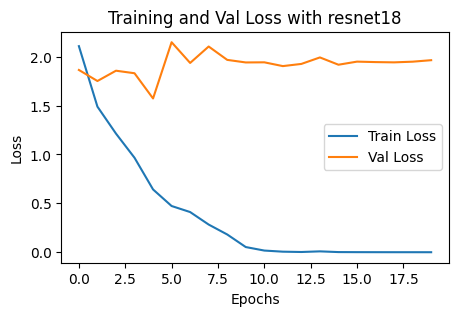

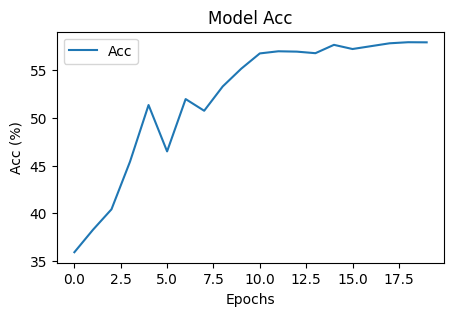

In [20]:
# resnet18 그래프 training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(train_losses_18, label='Train Loss')
plt.plot(val_losses_18, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Val Loss with resnet18')
plt.legend()
plt.show()

# accuracy
plt.figure(figsize=(5,3))
plt.plot(accuracies_18, label='Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc (%)')
plt.title('Model Acc')
plt.legend()
plt.show()


In [11]:
# train resnet 50
optimizer_50 = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.85)
train_losses_50, val_losses_50, accuracies_50 = train_model(resnet50, train_loader, test_loader, criterion, optimizer_50)

Epoch 1 - Train loss: 2.6850, Val loss: 2.5072, Accuracy: 15.97%
Epoch 2 - Train loss: 2.1870, Val loss: 2.2855, Accuracy: 19.41%
Epoch 3 - Train loss: 2.0619, Val loss: 2.2428, Accuracy: 23.66%
Epoch 4 - Train loss: 1.9755, Val loss: 1.9584, Accuracy: 22.56%
Epoch 5 - Train loss: 1.8799, Val loss: 1.8648, Accuracy: 27.06%
Epoch 6 - Train loss: 1.8052, Val loss: 1.9029, Accuracy: 28.02%
Epoch 7 - Train loss: 1.7858, Val loss: 1.7937, Accuracy: 31.25%
Epoch 8 - Train loss: 1.7405, Val loss: 1.7340, Accuracy: 31.55%
Epoch 9 - Train loss: 1.6763, Val loss: 1.6881, Accuracy: 32.36%
Epoch 10 - Train loss: 1.6781, Val loss: 1.7042, Accuracy: 34.48%
Epoch 11 - Train loss: 1.6262, Val loss: 1.6965, Accuracy: 34.49%
Epoch 12 - Train loss: 1.5950, Val loss: 1.6887, Accuracy: 33.99%
Epoch 13 - Train loss: 1.5538, Val loss: 1.6003, Accuracy: 37.65%
Epoch 14 - Train loss: 1.5181, Val loss: 1.5964, Accuracy: 37.38%
Epoch 15 - Train loss: 1.4688, Val loss: 1.5924, Accuracy: 39.17%
Epoch 16 - Train lo

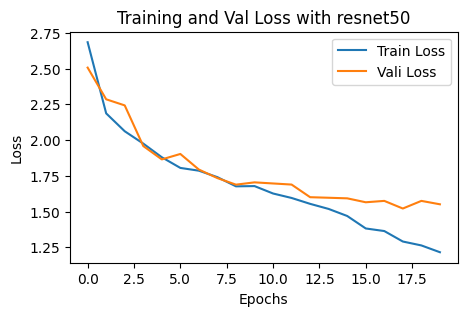

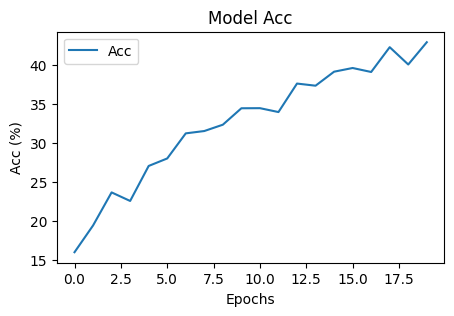

In [19]:
# resnet50 그래프 training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(train_losses_50, label='Train Loss')
plt.plot(val_losses_50, label='Vali Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Val Loss with resnet50')
plt.legend()
plt.show()

#  acc
plt.figure(figsize=(5, 3))
plt.plot(accuracies_50, label='Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc (%)')
plt.title('Model Acc')
plt.legend()
plt.show()


In [14]:
# train resnet 152
import torch.optim as optim
optimizer_152 = optim.SGD(resnet152.parameters(), lr=0.0001, momentum=0.9,weight_decay=0.0001)
train_losses_152, val_losses_152, accuracies_152 = train_model(resnet152, train_loader, test_loader, criterion, optimizer_152)

Epoch 1 - Train loss: 2.3521, Val loss: 2.3798, Accuracy: 10.49%
Epoch 2 - Train loss: 2.3463, Val loss: 2.3825, Accuracy: 10.50%
Epoch 3 - Train loss: 2.3398, Val loss: 2.3462, Accuracy: 10.54%
Epoch 4 - Train loss: 2.3334, Val loss: 2.3606, Accuracy: 10.51%
Epoch 5 - Train loss: 2.3274, Val loss: 2.3453, Accuracy: 10.51%
Epoch 6 - Train loss: 2.3160, Val loss: 2.3690, Accuracy: 10.54%
Epoch 7 - Train loss: 2.3207, Val loss: 2.3509, Accuracy: 10.55%
Epoch 8 - Train loss: 2.3181, Val loss: 2.3608, Accuracy: 10.40%
Epoch 9 - Train loss: 2.3133, Val loss: 2.3227, Accuracy: 10.54%
Epoch 10 - Train loss: 2.3130, Val loss: 2.3366, Accuracy: 10.49%
Epoch 11 - Train loss: 2.3127, Val loss: 2.3596, Accuracy: 10.54%
Epoch 12 - Train loss: 2.3081, Val loss: 2.3308, Accuracy: 10.54%
Epoch 13 - Train loss: 2.3054, Val loss: 2.3270, Accuracy: 10.50%
Epoch 14 - Train loss: 2.3038, Val loss: 2.3302, Accuracy: 10.45%
Epoch 15 - Train loss: 2.2992, Val loss: 2.3241, Accuracy: 10.50%
Epoch 16 - Train lo

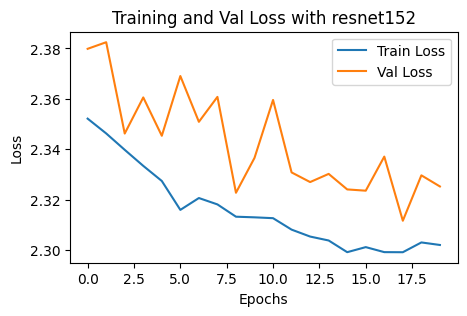

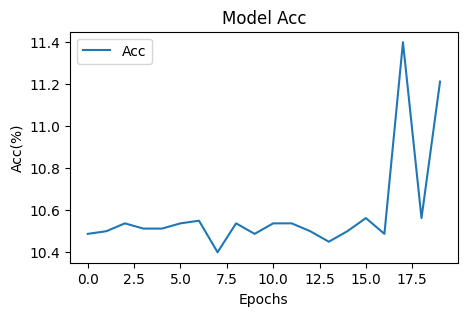

In [18]:
# resnet152 training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(train_losses_152, label='Train Loss')
plt.plot(val_losses_152, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Val Loss with resnet152')
plt.legend()
plt.show()

# resnet152 Plotting accuracy
plt.figure(figsize=(5, 3))
plt.plot(accuracies_152, label='Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc(%)')
plt.title('Model Acc')
plt.legend()
plt.show()
